In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import caffe
import itertools as it
import pandas as pd
import cv2
import scipy
import seaborn

from collections import defaultdict
from math import ceil
from copy import copy
from collections import OrderedDict
from operator import itemgetter, attrgetter
from matplotlib import pyplot
from scipy import ndimage as ndimage
from wurlitzer import pipes
from os.path import join as pjoin

from caffe import layers as L
from caffe import params as P
import tools

from ntb.layer.data import Transformer
from ntb.db import *

from training.util import *

%matplotlib inline
pyplot.rcParams['figure.figsize'] = (10, 6)

In [2]:
SUB_DIR = "ft_sigmoid_noaug_rmportraits_adam"

In [3]:
db = NTBDB()

# Data preparation

In [4]:
label_to_ntb = {
    'football': ['footbal', 'football-pitches', 'fotballs'],
    'person': ['full-length-portrait', 'portrait', 'persons'],
    'skiing': [
        'skiing', 'alpine-skiing', 'nordic-skiing', 'biathlon', 'freeskiing', 'freestyle-skiing', 'slalom', 'snowboarding', 'giant-slalom',
        'super-g', 'telemark-skiiing', 'downhill-skiing', 'nordic-combined', 'cross-country-skiing', 'ski-jumping', 'ski-orienteering',
        'long-distance-ski-races', 'ski-flying', 'relay-races', 'skis-and-ski-poles', 'ski-trips',
    ],
    'team-handball': ['team-handball'],
    'woman': ['women'],
    'child': ['children', 'girls', 'boys'],
    'skating': ['icehockey', 'skating', 'figure-skating'],
    'flag': ['flags'],
    'crowd': ['demonstrations', 'supporters', 'crowds'],
    'car': ['cars', 'ambulances', 'electric-cars', 'hybrid-cars', 'limousines', 'sports-cars', 'classic-cars', 'police-cars', 'automobile-racing', 'traffic'],
    'bicycling': ['bicycle-racing', 'bicycling', 'road-bicycle-racing', 'bicycles', 'cross-country-bicycling'],
    'flower': ['flowers', 'bouquet-of-flowers'],
    'man': ['men'],
    'medal': ['medals'],
    'snow': ['snow'],
    'hand': ['hands'],
    'triumph': ['sign-of-triumph'],
    'army': ['soldiers', 'the-armed-forces'],
    'boat': ['boats', 'yachting', 'ferries', 'sailboats', 'passenger-ships', 'cruise-ships', 'fishing-boats'],
    'norwegian-national-costumes': ['norwegian-national-costumes'],
    'landscape': ['landscape'],
    'signs': ['signs', 'traffic-signs'],
    'running': ['running-[athletics]', 'middle-distance-running', 'long-distance-running'],
    'aeroplane': ['aeroplanes'],
    'sky': ['sky', 'clouds'],
    'firemen': ['firemen'],
    'beach-volleyball': ['beach-volleyball'],
    'train': ['trains'],
    'umbrella': ['umbrellas'],
    'swimming': ['swimming-[sports]', 'swimming'],
    'dog': ['dogs'],
    'bus': ['buses'],
    'harbour': ['harbours'],
    'park': ['parks', 'forests'],
    'bridge': ['bridges'],
    'tree': ['trees'],
    'shoe': ['shoes'],
    'beach': ['beaches'],
    'helicopter': ['helicopters', 'rescue-helicopters'],
#     'red-carpet': ['red-carpet'],
#     'horse': ['horses'],
}
labels = np.asarray(sorted(label_to_ntb.keys()))
assert len(list(it.chain.from_iterable(label_to_ntb.values()))) == len(set(it.chain.from_iterable(label_to_ntb.values()))), "Dublicates"

In [5]:
ntb_to_label = {ntb_label: label for label, ntb_labels in label_to_ntb.items() for ntb_label in ntb_labels}

dataset = {
    label: set(it.chain.from_iterable(
        map(itemgetter('filename'), db.by_tag[ntb_label]) for ntb_label in ntb_labels
    )) for label, ntb_labels in label_to_ntb.items()
}

### Filtering out portrait pictures:

In [6]:
portrait_tags = {'portrait', u'press-conferences', u'coaches'}
include_portrait = {'child', 'hand', 'man', 'woman', 'triumph', 'umbrella', 'person', 'norwegian-national-costumes', 'medal'}
exclude_portrait = set(labels) - include_portrait
portrait_pics = set(map(itemgetter('filename'), it.chain.from_iterable(db.by_tag[pt] for pt in portrait_tags)))

In [7]:
excluded_df = {}
for label in dataset:
    if label not in exclude_portrait:
        excluded_df[label] = "-"
        continue
    before = dataset[label]
    after = before - portrait_pics
    dataset[label] = after
    rate = float(len(before) - len(after))/ len(before)
    excluded_df[label] = round(rate * 100, 2)

excluded_df = pd.DataFrame.from_dict(excluded_df, orient='index').rename(index=str, columns={0: 'excluded %'})

In [8]:
excluded_df.sort_values('excluded %', ascending=False)

,excluded %
umbrella,-
norwegian-national-costumes,-
triumph,-
person,-
man,-
medal,-
child,-
hand,-
woman,-
team-handball,22.94


### Labels distribution

In [9]:
def plot_distribution(data):
    pic_num_distribution = {
        label: len(imgs) for label, imgs in data.items()
    }
    data = sorted(pic_num_distribution.items(), key=itemgetter(1), reverse=True)
    df = pd.DataFrame.from_dict(OrderedDict(data), orient='index')
    df.plot(kind='bar', legend=False)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


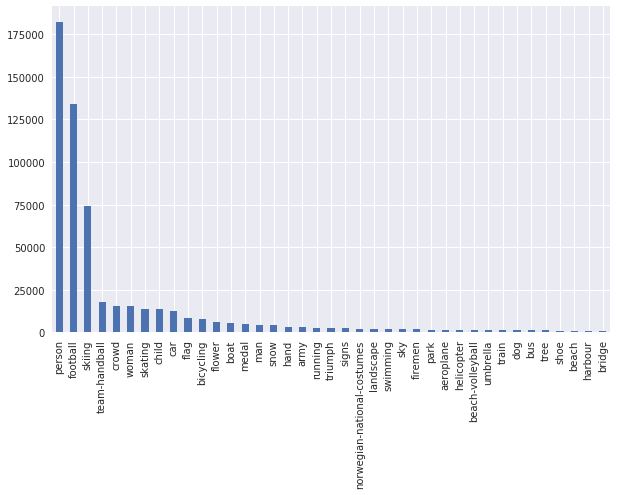

In [10]:
plot_distribution(dataset)

### Reducing imblalance

In [11]:
dataset_balanced = balance_dataset(dataset)
assert all(
    len(imgs - dataset[label]) == 0
    for label, imgs in dataset_balanced.items()
), "Some images are not in the right categories"
assert all(
    (label in exclude_portrait and img in portrait_pics) or img in dataset_balanced[label]
    for img in it.chain.from_iterable(dataset_balanced.values())
    for label in filter(None, map(lambda nl: ntb_to_label.get(nl, None), db.metadata[img]['tags']))
), "Check that image is in all categories"

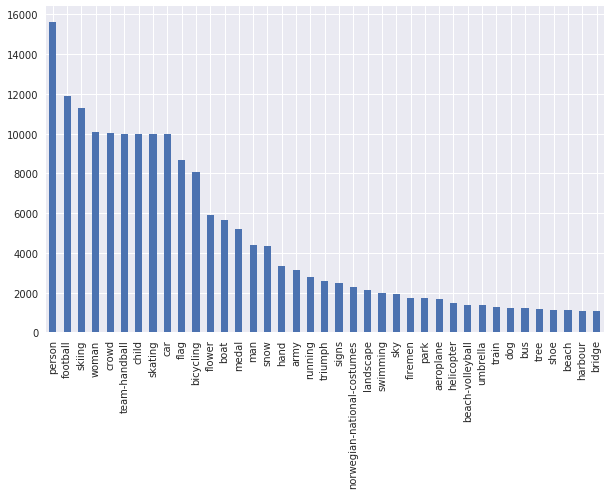

In [12]:
plot_distribution(dataset_balanced)

### Train/Validation/Test dataset split on per category basis

In [13]:
train, rest = split_dataset(dataset_balanced, 0.6)
val, test = split_dataset(rest, 0.5)
assert not set(it.chain.from_iterable(train.values())).intersection(set(it.chain.from_iterable(test.values())))
assert not set(it.chain.from_iterable(train.values())).intersection(set(it.chain.from_iterable(val.values())))
assert not set(it.chain.from_iterable(val.values())).intersection(set(it.chain.from_iterable(test.values())))

### Write sampled dataset to sub directory

In [14]:
data_dir = pjoin(BASE_DIR, 'nets', SUB_DIR, 'data')
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

def dump_training_data(data, split):
    training_data = {}
    for label, imgs in data.iteritems():
        for index in imgs:
            training_data.setdefault(index, {})
            if 'folder' not in training_data[index]:
                training_data[index]['folder'] = db.metadata[index]['folder']
            training_data[index].setdefault('labels', []).append(labels.tolist().index(label))
    data_path = pjoin(data_dir, split + '.pickle')
    with open(data_path, mode='w') as f:
        pickle.dump(training_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
dump_training_data(train, 'train')
dump_training_data(val, 'val')

In [22]:
with open(pjoin(data_dir, 'train_raw.pickle'), mode='w') as f:
    pickle.dump(train, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(pjoin(data_dir, 'val_raw.pickle'), mode='w') as f:
    pickle.dump(val, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(pjoin(data_dir, 'test_raw.pickle'), mode='w') as f:
    pickle.dump(test, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(pjoin(data_dir, 'labels.np'), mode='w') as f:
    labels.dump(f)

# Training

In [6]:
caffe.set_mode_gpu()

### Write nets and solver files

In [24]:
workdir = pjoin('/storage/ntb/nets', SUB_DIR)
if not os.path.isdir(workdir):
    os.makedirs(workdir)
snapshotsdir = os.path.join(workdir, 'snapshots')
if not os.path.isdir(snapshotsdir):
    os.makedirs(snapshotsdir)

logs_file_path = pjoin(workdir, 'train.log')
    
solverprototxt = tools.CaffeSolver(
    trainnet_prototxt_path=os.path.join(workdir, "trainnet.prototxt"),
    testnet_prototxt_path=os.path.join(workdir, "valnet.prototxt"),
)
solverprototxt.sp['base_lr'] = "0.0001"
solverprototxt.sp['display'] = "1"
solverprototxt.sp['snapshot'] = "100"
solverprototxt.sp['lr_policy'] = '"fixed"'
solverprototxt.sp['test_interval'] = "100"
solverprototxt.sp['test_iter'] = "1000"
solverprototxt.sp['max_iter'] = "1000"
solverprototxt.sp['momentum'] = "0.9"
solverprototxt.sp['snapshot_prefix'] = '"{}"'.format(os.path.join(snapshotsdir, 'snapshot'))
solverprototxt.write(os.path.join(workdir, 'solver.prototxt'))

base_data_layer_params = dict(
    batch_size=200,
    im_shape=[227, 227],
    ntb_root=BASE_DIR,
    sub_dir=SUB_DIR,
    num_labels=labels.size
)
# write train net.
with open(os.path.join(workdir, 'trainnet.prototxt'), 'w') as f:
    data_layer_params = dict(base_data_layer_params, split='train')
    f.write(caffenet_multilabel_sigmoid(SUB_DIR, labels.size, data_layer_params, is_test=False))

# write validation net.
with open(os.path.join(workdir, 'valnet.prototxt'), 'w') as f:
    data_layer_params = dict(base_data_layer_params, split='val', batch_size=20)
    f.write(caffenet_multilabel_sigmoid(SUB_DIR, labels.size, data_layer_params, is_test=False))
    
# write testing net.
with open(os.path.join(workdir, 'testnet.prototxt'), 'w') as f:
    f.write(caffenet_multilabel_sigmoid(SUB_DIR, labels.size, is_test=True))

### Load solver

In [25]:
solver = caffe.AdamSolver(os.path.join(workdir, 'solver.prototxt'))

BatchLoader initialized with 75205 images
NTBDataLayer initialized for sub_dir: ft_sigmoid_noaug_rmportraits_adam, split: train, with bs: 200, im_shape: [227, 227], num_labels: 39.
BatchLoader initialized with 26229 images
NTBDataLayer initialized for sub_dir: ft_sigmoid_noaug_rmportraits_adam, split: val, with bs: 20, im_shape: [227, 227], num_labels: 39.


### Start new training

In [22]:
try:
    os.remove(logs_file_path)
except:
    pass
solver.net.copy_from('/models/caffenet/bvlc_reference_caffenet.caffemodel')
solver.test_nets[0].share_with(solver.net)

### Restore from snapshot

In [26]:
for snapshot in sorted(os.listdir(snapshotsdir)):
    if snapshot.endswith('solverstate'):
        print snapshot

snapshot_iter_10.solverstate
snapshot_iter_100.solverstate
snapshot_iter_200.solverstate
snapshot_iter_300.solverstate
snapshot_iter_400.solverstate


In [29]:
solver.restore(os.path.join(snapshotsdir, 'snapshot_iter_400.solverstate'))
solver.test_nets[0].share_with(solver.net)

### Check images and labels

In [118]:
# transformer = Transformer(shape=[227, 227])
# image_index = 1
# pyplot.figure()
# pyplot.imshow(transformer.deprocess(copy(solver.net.blobs['data'].data[image_index, ...])))
# gtlist = solver.net.blobs['label'].data[image_index, ...].astype(np.int)
# pyplot.title('GT: {}'.format(labels[np.where(gtlist)]))
# pyplot.axis('off');

### Train network

In [30]:
%%time
with open(logs_file_path, mode='a') as logs_file:
    with pipes(stdout=logs_file, stderr=logs_file):
        solver.solve()

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 0 finished
Epoch 3 finished
Epoch 4 finished
CPU times: user 41min 43s, sys: 11min 49s, total: 53min 32s
Wall time: 2h 18min 17s


In [79]:
solver.snapshot()

### Look at some prediction results

In [ ]:
test_net = solver.test_nets[0]
for image_index in range(20):
    gtlist = test_net.blobs['label'].data[image_index, ...].astype(np.int)
    estlist = test_net.blobs['score'].data[image_index, ...] > 0
    if np.where(estlist)[0].any():
        plt.figure()
        plt.imshow(transformer.deprocess(copy(test_net.blobs['data'].data[image_index, ...])))
        plt.title('GT: {} \n EST: {}'.format(labels[np.where(gtlist)], labels[np.where(estlist)]))
        plt.axis('off')